In [108]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [109]:
dataset = load_dataset("mnist").with_format('np')
X_train_full = dataset["train"]['image']
Y_train_full = dataset["train"]['label']

X_test_full = dataset["test"]['image']
Y_test_full = dataset["test"]['label']


Found cached dataset mnist (/Users/gpetrov/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)
100%|██████████| 2/2 [00:00<00:00, 953.79it/s]


In [110]:
max_train_sample = 500

X_train = X_train_full[:max_train_sample].reshape(max_train_sample, 28 * 28).T / 255
Y_train = Y_train_full[:max_train_sample]

print(X_train.shape)
print(Y_train.shape)

(784, 500)
(500,)


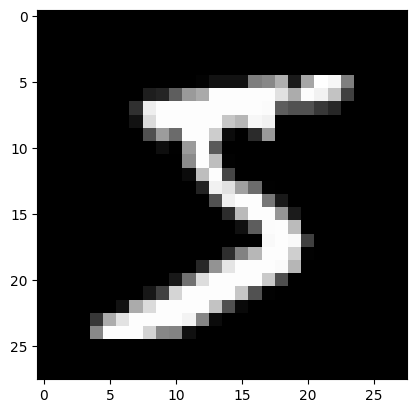

In [111]:
def plot_image(image):
  fig = plt.figure
  plt.imshow(image, cmap='gray')
  plt.show()

plot_image(X_train[:,0].reshape((28, 28)))

In [124]:
def sigmoid(x):
  return 1.0/(1.0 + np.exp(-x))

def relu(Z):
  return np.maximum(Z, 0)

def softmax(Z):
  A = np.exp(Z) / sum(np.exp(Z))
  return A

def deriv_relu(Z):
  return Z > 0

def deriv_sigmoid(x):
  sx = sigmoid(x)
  return sx * (1 - sx)

def one_hot_encode(y, length=10):
  m = y.shape[0]
  y_encoded = np.zeros((m, length))
  y_encoded[np.arange(m), y] = 1
  return y_encoded.T

def compute_cost(AL, y):
  m = y.shape[1]

  assert AL.shape == y.shape

  return 1/m * np.sum(np.square(AL - y))

def compute_accuracy(y_hat, y):

  # m = y_hat.shape[1]
  # assert y_hat.shape == y.shape
  # assert y_hat.shape[0] == 1

  return np.sum(y_hat == y) / y.size


def plot_cost(costs, accuracies, learning_rate):
  plt.plot(costs)
  plt.plot(accuracies)
  plt.ylabel('cost')
  plt.xlabel('iterations (per hundreds)')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()

  # display.clear_output(wait=True)
  # display.display(plt.gcf())

Loss = 90.99%, Accuracy = 14.40%
Loss = 90.46%, Accuracy = 14.60%
Loss = 89.97%, Accuracy = 15.80%
Loss = 89.51%, Accuracy = 16.00%
Loss = 89.07%, Accuracy = 17.00%
Loss = 88.65%, Accuracy = 18.80%
Loss = 88.23%, Accuracy = 20.20%
Loss = 87.82%, Accuracy = 22.40%
Loss = 87.41%, Accuracy = 24.60%
Loss = 86.99%, Accuracy = 25.60%
Loss = 86.58%, Accuracy = 28.40%
Loss = 86.15%, Accuracy = 29.40%
Loss = 85.72%, Accuracy = 31.20%
Loss = 85.27%, Accuracy = 32.00%
Loss = 84.82%, Accuracy = 33.80%
Loss = 84.35%, Accuracy = 34.80%
Loss = 83.87%, Accuracy = 37.40%
Loss = 83.37%, Accuracy = 40.00%
Loss = 82.86%, Accuracy = 41.60%
Loss = 82.33%, Accuracy = 44.20%
Loss = 81.78%, Accuracy = 46.20%
Loss = 81.22%, Accuracy = 46.60%
Loss = 80.63%, Accuracy = 48.80%
Loss = 80.03%, Accuracy = 51.00%
Loss = 79.40%, Accuracy = 52.00%
Loss = 78.76%, Accuracy = 53.40%
Loss = 78.09%, Accuracy = 54.60%
Loss = 77.40%, Accuracy = 56.80%
Loss = 76.68%, Accuracy = 58.00%
Loss = 75.94%, Accuracy = 59.00%
Loss = 75.

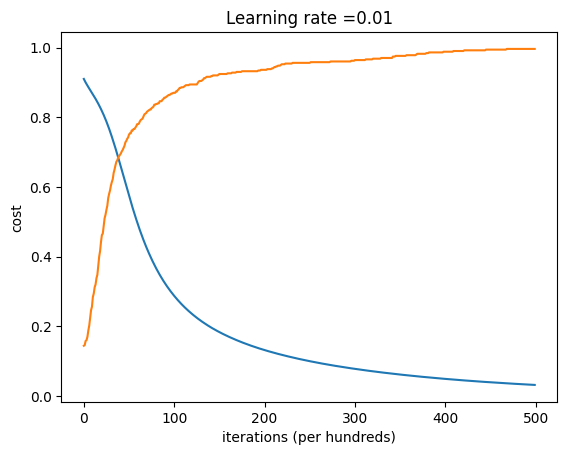

In [125]:
class Model:
  def __init__(self, layers_dims=[784, 512, 256, 128, 10], learning_rate=0.01, steps=50):

    self.steps = steps
    self.layers_dims = layers_dims
    self.nb_layers = len(layers_dims)
    self.cache = {}
    self.params = self.init_params(layers_dims)
    self.Y = np.array([])
    self.learning_rate = 0.01

    return

  def init_params(self, layers_dims):
    params = {}
    n_layers = len(layers_dims)

    for l in range(1, n_layers):
      params['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2 / layers_dims[l - 1])
      params['b' + str(l)] = np.zeros((layers_dims[l], 1))
    return params
  
  def forward(self, inputs):
    cache = {
        'A0': inputs
    }

    L = len(self.params) // 2

    for l in range(1, L):
      cache['Z' + str(l)] = self.params['W' + str(l)].dot(cache['A' + str(l - 1)]) + self.params['b' + str(l)]
      cache['A' + str(l)] = relu(cache['Z' + str(l)])
    

    cache['Z' + str(L)] = self.params['W' + str(L)].dot(cache['A' + str(L - 1)]) + self.params['b' + str(L)]
    cache['A' + str(L)] = softmax(cache['Z' + str(L)])

    self.cache = cache

  def backward(self, Y):
    """
    Arguments:
      Y: (10, m) matrix of one-hot encoded labels
    """
    L = len(self.params) // 2
    m = Y.shape[1]
    dZ = self.cache['A' + str(L)] - Y

    grads = {
      'Z' + str(L): dZ,
      'W' + str(L): 1/m * dZ.dot(self.cache['A' + str(L - 1)].T),
      'b' + str(L): 1/m * np.sum(dZ),
    }

    for l in reversed(range(1, L)):
      grads['Z' + str(l)] = self.params['W' + str(l + 1)].T.dot(grads['Z' + str(l + 1)]) * deriv_relu(self.cache['Z' + str(l)])
      grads['W' + str(l)] = 1/m * grads['Z' + str(l)].dot(self.cache['A' + str(l - 1)].T)
      grads['b' + str(l)] = 1/m * np.sum(grads['Z' + str(l)])

    self.grads = grads

  def update_params(self):
    for l in range(1, len(self.layers_dims)):
      self.params['W' + str(l)] -= self.learning_rate * self.grads['W' + str(l)]
      self.params['b' + str(l)] -= self.learning_rate * self.grads['b' + str(l)]

  # def compute_cost(self, Y):
  #   m = Y.shape[1]
  #   cost = -1/m * np.sum(Y * np.log(self.cache['A' + str(len(self.layers_dims) - 1)]))
  #   return cost

  def train(self, X, Y):
    """
    Arguments:
      inputs: (784, m) matrix
      steps: Number of training steps
    """
    costs = []
    accuracies = []

    Y_one_hot = one_hot_encode(Y, length=10)

    for i in range(0, self.steps):
      self.forward(X)

      self.backward(Y_one_hot)

      cost = compute_cost(self.cache['A' + str((len(self.params) // 2))], Y_one_hot)
      accuracy = compute_accuracy(np.argmax(self.cache['A' + str((len(self.params) // 2))], axis=0), Y)

      # print('Test Accurracy = {:.2f}%, Test Loss = {:.2f}%'.format(accuracy_test * 100, cost_test * 100))/
      print('Loss = {:.2f}%, Accuracy = {:.2f}%'.format(cost * 100, accuracy * 100))

      costs.append(cost)
      accuracies.append(accuracy)

      self.update_params()

    plot_cost(costs, accuracies, self.learning_rate)

    return
model = Model(layers_dims=[784, 512, 256, 128, 10], learning_rate=0.01, steps=500)

model.train(X_train, Y_train)
